# SimCLR Schedule Diagnostics

This notebook inspects SustainVision's SimCLR training schedule (pretrain + finetune) using the logged metrics stored in `outputs/SimCLR/SimCLR_2nd.csv`. All paths are relative to the repository root.


In [10]:
from pathlib import Path
import math

import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("seaborn-v0_8-darkgrid")

DATA_PATH = Path("outputs/SimCLR/SimCLR_2nd.csv")

df = pd.read_csv(DATA_PATH)
df["regime"] = df["phase"].apply(lambda phase: "pretrain" if "pretrain" in phase else "finetune")

pretrain_df = df[df["regime"] == "pretrain"].copy()
finetune_df = df[df["regime"] == "finetune"].copy()

finetune_start = finetune_df["epoch"].min() if not finetune_df.empty else None
best_finetune_epoch = None
best_finetune_val = None

if not finetune_df.empty:
    best_idx = finetune_df["val_accuracy"].idxmax()
    best_finetune_epoch = finetune_df.loc[best_idx, "epoch"]
    best_finetune_val = finetune_df.loc[best_idx, "val_accuracy"]

def mark_finetune_start(ax):
    if finetune_start is not None:
        ax.axvline(
            finetune_start,
            color="tab:red",
            linestyle="--",
            linewidth=1.25,
            label="Finetune start",
        )


def set_epoch_ticks(ax, step=100):
    xmin, xmax = ax.get_xlim()
    start = max(0, step * math.floor(xmin / step))
    end = step * math.ceil(xmax / step)
    ticks = list(range(int(start), int(end) + step, step))
    ax.set_xticks(ticks)


df.head()


,epoch,phase,loss_name,train_loss,train_accuracy,val_loss,val_accuracy,learning_rate,contrastive_train_loss,contrastive_val_loss,...,model,database,device,optimizer,loss_function,weight_decay,scheduler,seed,temperature,regime
0,1,pretrain_cycle_1,simclr,6.675614,0.0,6.607942,0.0,0.599991,6.675614,6.607942,...,resnet18,databases/cifar10,cuda:1,sgd,simclr,0.000001,"{'type': 'cosine_annealing', 'params': {'eta_m...",42,0.5,pretrain
1,2,pretrain_cycle_1,simclr,6.444722,0.0,6.441479,0.0,0.599963,6.444722,6.441479,...,resnet18,databases/cifar10,cuda:1,sgd,simclr,0.000001,"{'type': 'cosine_annealing', 'params': {'eta_m...",42,0.5,pretrain
2,3,pretrain_cycle_1,simclr,6.301001,0.0,6.322186,0.0,0.599917,6.301001,6.322186,...,resnet18,databases/cifar10,cuda:1,sgd,simclr,0.000001,"{'type': 'cosine_annealing', 'params': {'eta_m...",42,0.5,pretrain
3,4,pretrain_cycle_1,simclr,6.249069,0.0,6.383085,0.0,0.599852,6.249069,6.383085,...,resnet18,databases/cifar10,cuda:1,sgd,simclr,0.000001,"{'type': 'cosine_annealing', 'params': {'eta_m...",42,0.5,pretrain
4,5,pretrain_cycle_1,simclr,6.200077,0.0,6.347549,0.0,0.599769,6.200077,6.347549,...,resnet18,databases/cifar10,cuda:1,sgd,simclr,0.000001,"{'type': 'cosine_annealing', 'params': {'eta_m...",42,0.5,pretrain


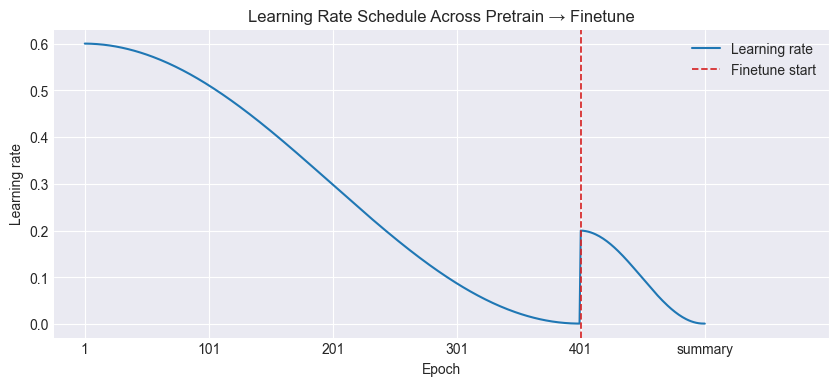

In [11]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df["epoch"], df["learning_rate"], color="tab:blue", label="Learning rate")
mark_finetune_start(ax)

ax.set_title("Learning Rate Schedule Across Pretrain → Finetune")
ax.set_xlabel("Epoch")
ax.set_ylabel("Learning rate")
set_epoch_ticks(ax)
ax.legend(loc="upper right")
plt.show()


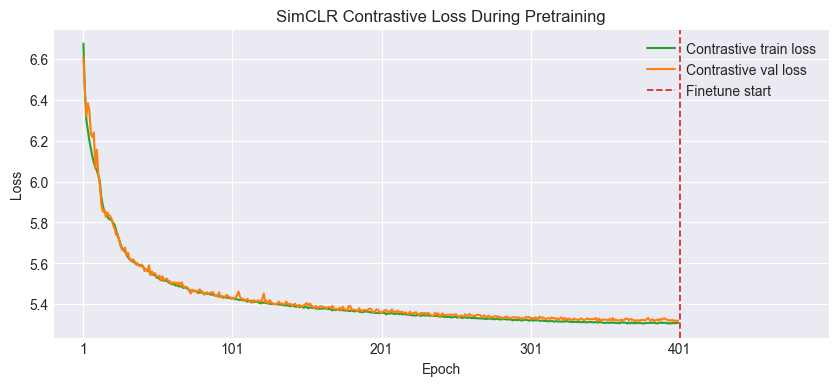

In [12]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    pretrain_df["epoch"],
    pretrain_df["contrastive_train_loss"],
    label="Contrastive train loss",
    color="tab:green",
)
ax.plot(
    pretrain_df["epoch"],
    pretrain_df["contrastive_val_loss"],
    label="Contrastive val loss",
    color="tab:orange",
)
mark_finetune_start(ax)

ax.set_title("SimCLR Contrastive Loss During Pretraining")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
set_epoch_ticks(ax)
ax.legend(loc="upper right")
plt.show()


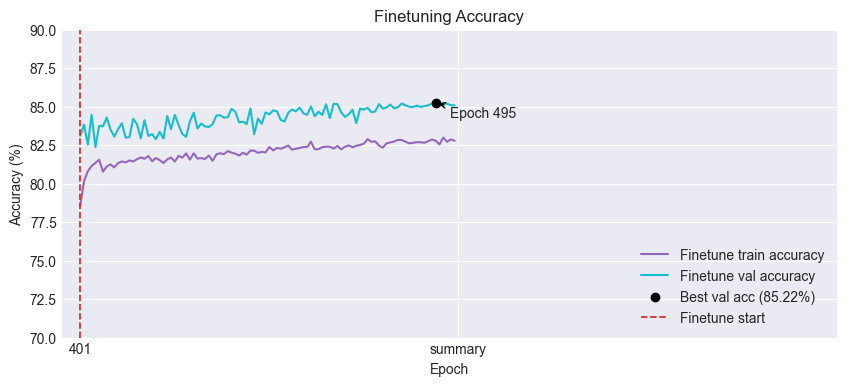

In [13]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    finetune_df["epoch"],
    finetune_df["train_accuracy"] * 100,
    label="Finetune train accuracy",
    color="tab:purple",
)
ax.plot(
    finetune_df["epoch"],
    finetune_df["val_accuracy"] * 100,
    label="Finetune val accuracy",
    color="tab:cyan",
)

if best_finetune_epoch is not None and best_finetune_val is not None:
    ax.scatter(
        best_finetune_epoch,
        best_finetune_val * 100,
        color="black",
        zorder=3,
        label=f"Best val acc ({best_finetune_val * 100:.2f}%)",
    )
    ax.annotate(
        f"Epoch {int(best_finetune_epoch)}",
        xy=(best_finetune_epoch, best_finetune_val * 100),
        xytext=(10, -10),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="->", color="black", linewidth=1),
    )

mark_finetune_start(ax)

ax.set_title("Finetuning Accuracy")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy (%)")
set_epoch_ticks(ax)
ax.set_ylim(70, 90)
ax.legend(loc="lower right")
plt.show()


In [19]:
%%time
from pathlib import Path
from torchvision import datasets

DATA_ROOT = Path("databases") / "cifar10"
DATA_ROOT.mkdir(parents=True, exist_ok=True)

_ = datasets.CIFAR10(
    root=str(DATA_ROOT),
    train=True,
    download=True,
    transform=None,
)
_ = datasets.CIFAR10(
    root=str(DATA_ROOT),
    train=False,
    download=True,
    transform=None,
)

print(f"CIFAR-10 ready at {DATA_ROOT.resolve()}")

100.0%


CIFAR-10 ready at C:\Users\sobha\Desktop\newresults\databases\cifar10
CPU times: total: 8.61 s
Wall time: 28.9 s


Unexpected keys: ['classifier.weight', 'classifier.bias']
Collected 5000 feature vectors of dim 512


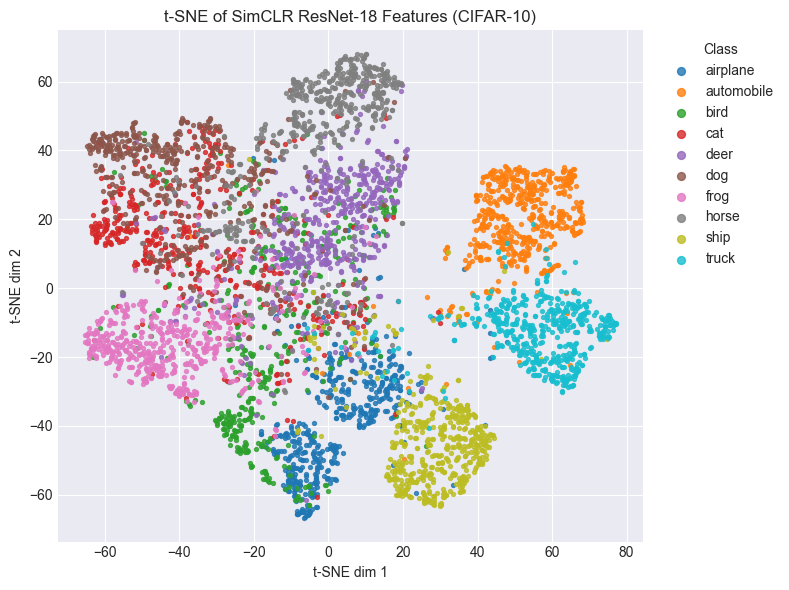

CPU times: total: 9min 1s
Wall time: 52.6 s


In [22]:
%%time
from pathlib import Path

import yaml
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

CFG_PATH = Path("outputs/SimCLR/SimCLR_2nd_model_1.yaml")
CKPT_PATH = Path("outputs/SimCLR/SimCLR_2nd_model_1.pt")
CIFAR_ROOT = Path("databases/cifar10")
SUBSET_SIZE = 5000
BATCH_SIZE = 128   # smaller batch for CPU
RANDOM_SEED = 42

device = torch.device("cpu")  # this laptop has no CUDA

with CFG_PATH.open() as f:
    cfg = yaml.safe_load(f)
    
def build_model(hidden_dim: int, out_dim: int) -> nn.Module:
    backbone = models.resnet18(weights=None)
    # Match SustainVision’s CIFAR-10 stem
    backbone.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    backbone.maxpool = nn.Identity()

    in_features = backbone.fc.in_features
    backbone.fc = nn.Identity()

    projector = nn.Sequential(
        nn.Linear(in_features, hidden_dim),
        nn.ReLU(inplace=True),
        nn.Linear(hidden_dim, out_dim),
    )

    class SimCLRNet(nn.Module):
        def __init__(self, backbone, projector):
            super().__init__()
            self.backbone = backbone
            self.projector = projector

        def forward(self, x, return_features: bool = False):
            feats = self.backbone(x)
            if return_features:
                return feats
            return self.projector(feats)

    return SimCLRNet(backbone, projector)

def load_checkpoint(model: nn.Module, ckpt_path: Path) -> nn.Module:
    payload = torch.load(ckpt_path, map_location="cpu")
    if isinstance(payload, dict):
        state = payload.get("model_state") or payload.get("state_dict") or payload
    else:
        state = payload
    cleaned = {}
    for k, v in state.items():
        key = k.replace("model.", "")
        if key.startswith("module."):
            key = key[len("module."):]
        cleaned[key] = v
    missing, unexpected = model.load_state_dict(cleaned, strict=False)
    if missing:
        print("Missing keys:", missing)
    if unexpected:
        print("Unexpected keys:", unexpected)
    return model

proj_hidden = int(cfg["hyperparameters"]["projection_hidden_dim"])
proj_out = int(cfg["hyperparameters"]["projection_dim"])

model = build_model(proj_hidden, proj_out)
model = load_checkpoint(model, CKPT_PATH)
model.eval()
for p in model.parameters():
    p.requires_grad_(False)

def simclr_linear_eval_transform(train: bool):
    if train:
        return transforms.Compose([
            transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ])
    return transforms.ToTensor()

val_dataset = datasets.CIFAR10(
    root=str(CIFAR_ROOT),
    train=False,
    download=False,
    transform=simclr_linear_eval_transform(train=False),
)

generator = torch.Generator().manual_seed(RANDOM_SEED)
subset_idx = torch.randperm(len(val_dataset), generator=generator)[:min(SUBSET_SIZE, len(val_dataset))]
subset = Subset(val_dataset, subset_idx.tolist())

loader = DataLoader(
    subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
)

all_feats, all_labels = [], []
with torch.inference_mode():
    for images, targets in loader:
        feats = model(images, return_features=True)
        all_feats.append(feats)
        all_labels.append(targets)

features = torch.cat(all_feats).numpy()
labels = torch.cat(all_labels).numpy()
print(f"Collected {features.shape[0]} feature vectors of dim {features.shape[1]}")

embeddings = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    init="pca",
    random_state=RANDOM_SEED,
).fit_transform(features)

plt.figure(figsize=(8, 6))
colors = plt.cm.tab10(np.linspace(0, 1, len(val_dataset.classes)))
for idx, cls_name in enumerate(val_dataset.classes):
    mask = labels == idx
    plt.scatter(
        embeddings[mask, 0],
        embeddings[mask, 1],
        s=8,
        alpha=0.8,
        color=colors[idx],
        label=cls_name,
    )
plt.title("t-SNE of SimCLR ResNet-18 Features (CIFAR-10)")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.legend(markerscale=2, bbox_to_anchor=(1.02, 1), loc="upper left", title="Class")
plt.tight_layout()
plt.show()

The t-SNE clusters are cleanly separated for vehicles (car/truck) and animals, with only minor overlap between visually similar classes (cat vs. dog). This indicates the frozen SimCLR backbone still preserves class-discriminative structure even before the projection head.


### Quick takeaways

- The cosine schedule shows a smooth decay from the high pretrain learning rate (~0.6) toward the finetune floor (0.001) with a clear regime change marked by the dashed boundary line.
- Contrastive train/val losses steadily decrease and converge before finetuning begins, confirming the pretraining run reached a stable contrastive optimum.
- Finetune accuracy climbs quickly, with validation peaking just above 85% (annotated on the plot) and staying flat, indicating the model saturates without clear overfitting at the end of the schedule.
